In [1]:
!git clone https://github.com/asperti/MicroRacer.git


Cloning into 'MicroRacer'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 264 (delta 98), reused 84 (delta 84), pack-reused 144
Receiving objects: 100% (264/264), 1.42 MiB | 10.05 MiB/s, done.
Resolving deltas: 100% (127/127), done.


## Setting up environment

In [2]:
# Import libraries
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
#import tensorflow_probabilities as tpf
import numpy as np
import matplotlib.pyplot as plt
from MicroRacer import tracks

In [4]:
# Define the racer object.
racer = tracks.Racer(obstacles=True,
                     turn_limit=True,
                     chicanes=True,
                     low_speed_termination=True)

# Generate a new track and get the starting state s_0
start_state = racer.reset()


initial speed =  0.4213772195111265


In [7]:

# Parameters
num_states = 5 #we reduce the state dim through observation
num_actions = 2 #acceleration and steering
print("State Space dim: {}, Action Space dim: {}".format(num_states,num_actions))

upper_bound = 1
lower_bound = -1
print("Min and Max Value of Action: {}".format(lower_bound,upper_bound))

# Discount factor
gamma = 0.99 #to give more importance to errors closer in time 

# Buffer settings
buffer_dim = 50000 #useful to avoid computations when doing same operations multiple times
batch_size = 64

State Space dim: 5, Action Space dim: 2
Min and Max Value of Action: -1


## DDPG (Deep Deterministic Policy Gradient)
DDPG (Deep Deterministic Policy Gradient) is an extension of Deep Q-Learning to the continuous action-state setup. It is here implemented by an Actor-Critic setup, where the Actor takes as input the state 
 and decides the action 
, while the critic takes the state 
 and the action, decided by the Actor, and returns the Q-value 
.

The actor is thus implemented as a Fully-Connected Neural Network, taking as imput the actual state 
 and returning a tuple 
, representing the turning angle and the acceleration, respectively.

In [8]:
#The actor choose the move, given the state
def get_actor(train_acceleration=True,train_direction=True):
    # the actor has separate towers for action and speed
    # in this way we can train them separately

    inputs = layers.Input(shape=(num_states,))
    out1 = layers.Dense(32, activation="relu", trainable=train_acceleration)(inputs)
    out1 = layers.Dense(32, activation="relu", trainable=train_acceleration)(out1)
    out1 = layers.Dense(1, activation='tanh', trainable=train_acceleration)(out1)

    out2 = layers.Dense(32, activation="relu", trainable=train_direction)(inputs)
    out2 = layers.Dense(32, activation="relu",trainable=train_direction)(out2)
    out2 = layers.Dense(1, activation='tanh',trainable=train_direction)(out2)

    outputs = layers.concatenate([out1,out2]) #output it's the decided actions (direction and acceleration)

    #outputs = outputs * upper_bound #resize the range, if required
    model = tf.keras.Model(inputs, outputs, name="actor")
    return model

The critic computes q-value.

Takes state and action, processes them separately with dense layers, concatenates the results and processes it again with 2 more dense layers, and outputs a single value with relu activation.

In [9]:
# The critic computes the q-value, given the state and the action (2 inputs)
def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out]) #concatenates processed inputs to generate a single output

    out = layers.Dense(64, activation="relu")(concat)
    out = layers.Dense(64, activation="relu")(out)
    outputs = layers.Dense(1)(out) #Outputs single value

    model = tf.keras.Model([state_input, action_input], outputs, name="critic")

    return model

The Actor and the Critic model can be chained together such that the output of the Actor get feeded into the input of the Critic.

since q-value requires the taken action as imput, decided by the actor model (DEEP Q-LEARNING)

In [10]:
#We compose actor and critic in a single model.
#The actor is trained by maximizing the future expected reward, estimated
#by the critic. The critic should be freezed while training the actor.
#For simplicitly, we just use the target critic, that is not trainable.
def compose(actor,critic):
    state_input = layers.Input(shape=(num_states))
    a = actor(state_input)
    q = critic([state_input,a])

    m = tf.keras.Model(state_input, q)
    #the loss function of the compound model is just the opposite of the critic output
    m.add_loss(-q)
    return(m)

The training is performed in such a way that the Critic estimation becomes closer and closer to 
Q(s,a), while the Actor (that approximates the action of 
) approaches the optimal policy.

In [11]:
# creating models
actor_model = get_actor()
critic_model = get_critic()

# we create the target model for double learning (to prevent a moving target phenomenon)
target_actor = get_actor()
target_critic = get_critic()

# make target models non trainable.
target_actor.trainable = False
target_critic.trainable = False

# Compose the models in a single one.
aux_model = compose(actor_model, critic_model)

Defining the buffer

In [12]:
#Replay buffer
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Max Number of tuples that can be stored
        self.buffer_capacity = buffer_capacity
        # Num of tuples used for training
        self.batch_size = batch_size

        # Current number of tuples in buffer
        self.buffer_counter = 0

        # We have a different array for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.done_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Stores a transition (s,a,r,s') in the buffer
    def record(self, obs_tuple):
        s,a,r,T,sn = obs_tuple
        # restart form zero if buffer_capacity is exceeded, replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = tf.squeeze(s)
        self.action_buffer[index] = a
        self.reward_buffer[index] = r
        self.done_buffer[index] = T
        self.next_state_buffer[index] = tf.squeeze(sn)

        self.buffer_counter += 1

    def sample_batch(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        s = self.state_buffer[batch_indices]
        a = self.action_buffer[batch_indices]
        r = self.reward_buffer[batch_indices]
        T = self.done_buffer[batch_indices]
        sn = self.next_state_buffer[batch_indices]
        return ((s,a,r,T,sn))

Then, we define the policy. We use a kind of 
$ϵ$-greedy policy, where noise is added to the choice of the Actor, to favor the exploration of the Environment.

In [13]:
def policy(state, verbose=False):
    #the policy used for training just add noise to the action
    #the amount of noise is kept constant during training
    sampled_action = tf.squeeze(actor_model(state))
    noise = np.random.normal(scale=0.1,size=2)

    #we may change the amount of noise for actions during training
    noise[0] *= 2
    noise[1] *= .5

    # Adding noise to action
    sampled_action = sampled_action.numpy()
    sampled_action += noise

    #in verbose mode, we may print information about selected actions
    if verbose and sampled_action[0] < 0:
        print("decelerating")

    #Finally, we ensure actions are within bounds
    legal_action = np.clip(sampled_action, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

## Train
Finally, we define the function that trains the model and we lunch it.



In [15]:
# Hyperparameters
total_iterations = 50_000

# Target network parameter update factor, for double DQN
tau = 0.005

# Learning rate for actor-critic models
critic_lr = 0.001
aux_lr = 0.001

is_training = False

load_weights = True
save_weights = True

weights_file_actor = "./MicroRacer/weights/ddpg_actor_model_car"
weights_file_critic = "./MicroRacer/weights/ddpg_critic_model_car"



# Slowly updating target parameters according to the tau rate <<1
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def update_weights(target_weights, weights, tau):
    return(target_weights * (1- tau) +  weights * tau)



## TRAINING ##
if load_weights:
    critic_model = keras.models.load_model(weights_file_critic)
    actor_model = keras.models.load_model(weights_file_actor)

# Making the weights equal initially
target_actor_weights = actor_model.get_weights()
target_critic_weights = critic_model.get_weights()
target_actor.set_weights(target_actor_weights)
target_critic.set_weights(target_critic_weights)

# Define the optimizer
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
aux_optimizer = tf.keras.optimizers.Adam(aux_lr)

# Compile the models
critic_model.compile(loss='mse',optimizer=critic_optimizer)
aux_model.compile(optimizer=aux_optimizer)

# Create the buffer
buffer = Buffer(buffer_dim, batch_size)

# History of rewards per episode
ep_reward_list = []
# Average reward history of last few episodes
avg_reward_list = []         

# We introduce a probability of doing n empty actions to separate the environment time-step from the agent
def step(action):
    n = 1
    t = np.random.randint(0,n)
    state ,reward,done = racer.step(action)
    for i in range(t):
        if not done:
            state ,t_r, done = racer.step([0, 0])
            #state ,t_r, done =racer.step(action)
            reward+=t_r
    return (state, reward, done)


def train(total_iterations=total_iterations):
    i = 0
    mean_speed = 0
    ep = 0
    avg_reward = 0
    while i<total_iterations:

        prev_state = racer.reset()
        episodic_reward = 0
        mean_speed += prev_state[num_states-1]
        done = False
        while not(done):
            i = i+1
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
            #our policy is always noisy
            action = policy(tf_prev_state)[0]
            # Get state and reward from the environment
            state, reward, done = step(action)
            
            #we distinguish between termination with failure (state = None) and succesfull termination on track completion
            #succesfull termination is stored as a normal tuple
            fail = done and len(state)<num_states 
            buffer.record((prev_state, action, reward, fail, state))
            if not(done):
                mean_speed += state[num_states-1]
        
            episodic_reward += reward

            if buffer.buffer_counter>batch_size:
                states,actions,rewards,dones,newstates= buffer.sample_batch()
                targetQ = rewards + (1-dones)*gamma*(target_critic([newstates,target_actor(newstates)]))
                loss1 = critic_model.train_on_batch([states,actions],targetQ)
                loss2 = aux_model.train_on_batch(states)

                update_target(target_actor.variables, actor_model.variables, tau)
                update_target(target_critic.variables, critic_model.variables, tau)
            prev_state = state
            
            if i%100 == 0:
                avg_reward_list.append(avg_reward)
                

        ep_reward_list.append(episodic_reward)

        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list[-40:])
        print("Episode {}: Iterations {}, Avg. Reward = {}, Last reward = {}. Avg. speed = {}".format(ep, i, avg_reward,episodic_reward,mean_speed/i))
        print("\n")
        
        if ep>0 and ep%40 == 0:
            print("## Evaluating policy ##")
            tracks.metrics_run(actor_model, 10)
        ep += 1
        

    if total_iterations > 0:
        if save_weights:
            critic_model.save(weights_file_critic)
            actor_model.save(weights_file_actor)
        # Plotting Episodes versus Avg. Rewards
        plt.plot(avg_reward_list)
        plt.xlabel("Training steps x100")
        plt.ylabel("Avg. Episodic Reward")
        plt.ylim(-3.5,7)
        plt.show(block=False)
        plt.pause(0.001)
        print("### DDPG Training ended ###")
        print("Trained over {} steps".format(i))

# Rung training
if is_training:
    start_t = datetime.now()
    train()
    end_t = datetime.now()
    print("Time elapsed: {}".format(end_t-start_t))

Note: each row is an episode (a full execution of the code).
For each one we have a summary. When the reward gets positive, it means it compleated a track.

Problem: this takes at least around 50000 iterations (very innefficient), which is hours of training!



In [16]:
# The model we will use to compete is the Actor model
ddpg_model = actor_model

## DDPG2

As already mentioned, DDPG2 is a variant of DDPG where noise is added to the parameter to stabilize training. The implementation is basically the same we used for DDPG.

In [17]:
# Parameters
total_iterations = 50000

# Discount factor
gamma = 0.99

# Target network parameter update factor, for double DQN
tau = 0.005

# Learning rate for actor-critic models
critic_lr = 0.001
aux_lr = 0.001

param_noise_stddev = 0.2

is_training = False

load_weights = True
save_weights = True #beware when saving weights to not overwrite previous data

weights_file_actor = "MicroRacer/weights/ddpg2_actor_model_car"
weights_file_critic = "MicroRacer/weights/ddpg2_critic_model_car"


#The actor choose the move, given the state
def get_actor():

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(64, name="perturbable1", activation="relu")(inputs)
    out = layers.LayerNormalization()(out)
    out = layers.Dense(64, name="perturbable2", activation="relu")(out)
    out = layers.LayerNormalization()(out)
    outputs = layers.Dense(num_actions, name="perturbable3", activation="tanh")(out)

    model = tf.keras.Model(inputs, outputs, name="actor")
    return model
    

#the critic compute the q-value, given the state and the action
def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(64, activation="relu")(concat)
    out = layers.Dense(64, activation="relu")(out)
    outputs = layers.Dense(1)(out) #Outputs single value

    model = tf.keras.Model([state_input, action_input], outputs, name="critic")

    return model


#creating models
actor_model = get_actor()
critic_model = get_critic()

#we create the target model for double learning (to prevent a moving target phenomenon)
target_actor = get_actor()
target_critic = get_critic()
target_actor.trainable = False
target_critic.trainable = False

#We compose actor and critic in a single model.
#The actor is trained by maximizing the future expected reward, estimated
#by the critic. The critic should be freezed while training the actor.
#For simplicitly, we just use the target critic, that is not trainable.
def compose(actor,critic):
    state_input = layers.Input(shape=(num_states))
    a = actor(state_input)
    q = critic([state_input,a])
    #reg_weights = actor.get_layer('out').get_weights()[0]
    #print(tf.reduce_sum(0.01 * tf.square(reg_weights)))

    m = tf.keras.Model(state_input, q)
    #the loss function of the compound model is just the opposite of the critic output
    m.add_loss(-q)
    return(m)



## ONLY MODIFICATION TO DDPG:
# Updates weigths of the perturbed actor inserting noise too
def get_perturbed_actor_updates(actor, perturbed_actor, param_noise_stddev):
    updates = []
    for var, perturbed_var in zip(actor.trainable_variables, perturbed_actor.trainable_variables):
        if "perturbable" in var.name:
            updates.append(perturbed_var.assign( var + tf.random.normal(tf.shape(var), mean=0., stddev=param_noise_stddev)))
    return tf.group(*updates)

# Calculates distance between perturbed actor and clean actor and uses it to update standard deviation
def adapt_param_noise(actor, adaptive_actor, states,current_stddev):
    adoption_coefficient=1.01
    # Perturb a separate copy of the policy to adjust the scale for the next "real" perturbation.
    perturb_adaptive_policy_ops = get_perturbed_actor_updates(actor, adaptive_actor, current_stddev)
    distance = tf.sqrt(tf.reduce_mean(tf.square(actor(states) - adaptive_actor(states))))
    
    if distance > current_stddev:
        # Decrease stddev.
        current_stddev /= adoption_coefficient
    else:
        # Increase stddev.
        current_stddev *= adoption_coefficient
    return current_stddev

aux_model = compose(actor_model,target_critic)

# Configure perturbed actor.
param_noise_actor = get_actor()
perturb_policy_ops = get_perturbed_actor_updates(actor_model, param_noise_actor, param_noise_stddev)

# Configure separate copy for stddev adoption.
adaptive_param_noise_actor = get_actor()
perturb_adaptive_policy_ops = get_perturbed_actor_updates(actor_model, adaptive_param_noise_actor, param_noise_stddev)

In [18]:
#Replay buffer
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Max Number of tuples that can be stored
        self.buffer_capacity = buffer_capacity
        # Num of tuples used for training
        self.batch_size = batch_size

        # Current number of tuples in buffer
        self.buffer_counter = 0

        # We have a different array for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.done_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Stores a transition (s,a,r,s') in the buffer
    def record(self, obs_tuple):
        s,a,r,T,sn = obs_tuple
        # restart form zero if buffer_capacity is exceeded, replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = tf.squeeze(s)
        self.action_buffer[index] = a
        self.reward_buffer[index] = r
        self.done_buffer[index] = T
        self.next_state_buffer[index] = tf.squeeze(sn)

        self.buffer_counter += 1

    def sample_batch(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        s = self.state_buffer[batch_indices]
        a = self.action_buffer[batch_indices]
        r = self.reward_buffer[batch_indices]
        T = self.done_buffer[batch_indices]
        sn = self.next_state_buffer[batch_indices]
        return ((s,a,r,T,sn))

buffer = Buffer(buffer_dim, batch_size)

In [19]:
# Slowly updating target parameters according to the tau rate <<1
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def update_weights(target_weights, weights, tau):
    return(target_weights * (1- tau) +  weights * tau)

def policy(state,verbose=False):
    add_action_noise = False
    # we use the actor modified with parametric noise to generate the action
    sampled_action = tf.squeeze(param_noise_actor(state))
    if add_action_noise:
        noise = np.random.normal(scale=0.1,size=2)
        #we may change the amount of noise for actions during training
        noise[0] *= 2
        noise[1] *= .5
        # Adding noise to action
        sampled_action = sampled_action.numpy()
        sampled_action += noise
    #in verbose mode, we may print information about selected actions
    if verbose and sampled_action[0] < 0:
        print("decelerating")

    #Finally, we ensure actions are within bounds
    legal_action = np.clip(sampled_action, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


## TRAINING ##
if load_weights:
    critic_model = keras.models.load_model(weights_file_critic)
    actor_model = keras.models.load_model(weights_file_actor)

# Making the weights equal initially
target_actor_weights = actor_model.get_weights()
target_critic_weights = critic_model.get_weights()
target_actor.set_weights(target_actor_weights)
target_critic.set_weights(target_critic_weights)



critic_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(critic_lr))
aux_model.compile(optimizer=tf.keras.optimizers.Adam(aux_lr))


# History of rewards per episode
ep_reward_list = []
# Average reward history of last few episodes
avg_reward_list = []


# We introduce a probability of doing n empty actions to separate the environment time-step from the agent   
def step(action):
    n = 1
    t = np.random.randint(0,n)
    state ,reward,done = racer.step(action)
    for i in range(t):
        if not done:
            state ,t_r, done =racer.step([0, 0])
            #state ,t_r, done =racer.step(action)
            reward+=t_r
    return (state, reward, done)


def train(total_iterations=total_iterations):
    i = 0
    mean_speed = 0
    current_stddev = param_noise_stddev
    ep = 0
    avg_reward = 0
    while i<total_iterations:
        prev_state = racer.reset()
        episodic_reward = 0
        mean_speed += prev_state[4]
        done = False
        while not(done):
            i = i+1
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
            #our policy is always noisy
            action = policy(tf_prev_state)[0]
            # Get state and reward from the environment
            state, reward, done = step(action)
            
            #we distinguish between termination with failure (state = None) and succesfull termination on track completion
            #succesfull termination is stored as a normal tuple
            fail = done and len(state)<5 
            buffer.record((prev_state, action, reward, fail, state))
            if not(done):
                mean_speed += state[4]
        
            episodic_reward += reward

            if buffer.buffer_counter>batch_size:
                states,actions,rewards,dones,newstates= buffer.sample_batch()
                targetQ = rewards + (1-dones)*gamma*(target_critic([newstates,target_actor(newstates)]))
                loss1 = critic_model.train_on_batch([states,actions],targetQ)
                loss2 = aux_model.train_on_batch(states)

                update_target(target_actor.variables, actor_model.variables, tau)
                update_target(target_critic.variables, critic_model.variables, tau)
                
                # We calculate adapted standard devation at every step
                current_stddev = adapt_param_noise(actor_model, adaptive_param_noise_actor, states,current_stddev)
            prev_state = state
            
            if i%100 == 0:
                avg_reward_list.append(avg_reward)
        
        # We update the perturbed actor parametric noise only after an episode
        perturb_policy_ops = get_perturbed_actor_updates(actor_model, param_noise_actor, current_stddev)

        ep_reward_list.append(episodic_reward)

        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list[-40:])
        print("Episode {}: Iterations {}, Avg. Reward = {}, Last reward = {}. Avg. speed = {}".format(ep, i, avg_reward,episodic_reward,mean_speed/i))
        print("\n")
        
        if ep>0 and ep%40 == 0:
            print("## Evaluating policy ##")
            tracks.metrics_run(actor_model, 10)
        ep += 1

    if total_iterations > 0:
        if save_weights:
            critic_model.save(weights_file_critic)
            actor_model.save(weights_file_actor)
        # Plotting Episodes versus Avg. Rewards
        plt.plot(avg_reward_list)
        plt.xlabel("Training steps x100")
        plt.ylabel("Avg. Episodic Reward")
        plt.ylim(-3.5,7)
        plt.show(block=False)
        plt.pause(0.001)
        print("### DDPG2 Training ended ###")
        print("Trained over {} steps".format(i))

if is_training:
    start_t = datetime.now()
    train()
    end_t = datetime.now()
    print("Time elapsed: {}".format(end_t-start_t))

In [20]:
# To compete, we will be use the actor model
ddpg2_model = actor_model

## PPO (Proximal Policy Optimization)

PPO is a policy-gradient technique, i.e. where we assume the policy to be continuous and we explicitely train on it. Its main difference w.r.t. classical policy-gradient methods is that it clips the objective function to ensure that the deviation from the previous policy is relatively small. The differences with the other two models, in terms of code, are negligible.

Note that here the Actor does not returns the action to perform, but the mean and the standard deviation of the Gaussian distribution defining the action to consider. In particular, the actor 
 here models Gaussian distribution N(at|A(st))
 instead of explicitly generates an action 
. The training code is easier since we are forced to use the tensorflow_probability package, which does the biggest portion of the job authomatically.

In [21]:
#actor just returns mean and variance. the critic samples actions from it
#The actor choose the move, given the state
class Get_actor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = layers.Dense(64, activation="tanh")
        self.d2 = layers.Dense(64, activation="tanh")
        self.m = layers.Dense(num_actions, activation="tanh")
        
    def call(self, s):
        out = self.d1(s)
        out = self.d2(out)
        mu = self.m(out)
        sigma = 0.2
        return  mu, sigma
    
    @property  
    def trainable_variables(self):
        return self.d1.trainable_variables + \
                self.d2.trainable_variables + \
                self.m.trainable_variables


#the critic compute the value, given the state 
class Get_critic(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = layers.Dense(64, activation="tanh")
        self.d2 = layers.Dense(64, activation="tanh")
        self.o = layers.Dense(1)
        
    def call(self, inputs):
        out = self.d1(inputs)
        out = self.d2(out)
        q = self.o(out)
        return q
    
    @property
    def trainable_variables(self):
        return self.d1.trainable_variables + \
                self.d2.trainable_variables + \
                self.o.trainable_variables

class Agent:
    def __init__(self):
        self.racer = tracks.Racer()
        self.actor_model = Get_actor()
        self.critic_model = Get_critic()
        self.buffer = Buffer(batch_size)     
        ## TRAINING ##
        self.critic_model(layers.Input(shape=(num_states)))
        self.actor_model(layers.Input(shape=(num_states)))
        if load_weights:
            self.critic_model = keras.models.load_model(weights_file_critic)
            self.actor_model = keras.models.load_model(weights_file_actor)
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
        self.actor_model.compile(optimizer=self.actor_optimizer)
        self.critic_model.compile(loss="mse",optimizer=self.critic_optimizer)
        # History of rewards per episode
        self.ep_reward_list = []
        # Average reward history of last few episodes
        self.avg_reward_list = []
        # Keep track of how many training steps has been done
        
    #Returns an action sampled from the normal distribution returned by the actor and it's relative log probability.
    #If an action is passed returns it's log probability.
    def get_action_and_logp(self, states, actions=None):
        mu, sigma = self.actor_model(states)
        dist = tfp.distributions.Normal(mu, sigma)
        if actions is None:
            # Use of the reparameterization trick 
            actions = mu + sigma * tfp.distributions.Normal(0,1).sample(num_actions)   
        log_p = dist.log_prob(actions)
        
        if len(log_p.shape)>1:
            log_p = tf.reduce_sum(log_p,1)
        else:
            log_p = tf.reduce_sum(log_p)
        log_p = tf.expand_dims(log_p, 1)
        
        valid_action  = K.clip(actions, lower_bound, upper_bound)
        
        return  valid_action, log_p
        
        
    def gae(self, values, rewards, masks, lastvalue):
        returns = []
        gae = 0
        for i in reversed(range(len(rewards))):
            if i==len(rewards)-1:
                nextvalue=lastvalue
            else:
                nextvalue=values[i+1]
            delta=rewards[i]+gamma*nextvalue*masks[i]-values[i]  
            gae=delta+gamma*gae_lambda*masks[i]*gae
            returns.insert(0, gae+values[i])
        advantages = returns - values
        advantages = (advantages - tf.reduce_mean(advantages)) / (tf.math.reduce_std(advantages) + 1e-8)
        return np.array(returns), advantages
    
    def update_networks(self, last_value=0): 
        states, actions, rewards, dones, values, old_logp, batches = self.buffer.sample_batch()
        returns, advantages = self.gae(values, rewards, dones, last_value)     
        # Train using mini-batches
        for batch in batches:
            s_batch = tf.convert_to_tensor(states[batch], dtype=tf.float32)
            a_batch = tf.convert_to_tensor(actions[batch], dtype=tf.float32)
            adv_batch = tf.expand_dims(tf.convert_to_tensor(advantages.numpy()[batch], dtype=tf.float32),1)
            ret_batch =  tf.expand_dims(tf.convert_to_tensor(returns[batch], dtype=tf.float32),1)
            ologp_batch = tf.expand_dims(tf.convert_to_tensor(old_logp[batch], dtype=tf.float32),1)
            for e in range(epochs):
                with tf.GradientTape() as tape:
                    tape.watch(self.actor_model.trainable_variables)
                    _,logp_batch = self.get_action_and_logp(tf.stack(s_batch), tf.stack(a_batch)) 
                    ratio = tf.exp(logp_batch-ologp_batch)
                    weighted_ratio = ratio*adv_batch
                    weighted_clipped_ratio = tf.clip_by_value(ratio, clip_value_min=1- policy_clip, clip_value_max=1+ policy_clip)*adv_batch
                    min_wr = tf.minimum(weighted_ratio, weighted_clipped_ratio)- target_entropy*logp_batch
                    loss = -tf.reduce_mean(min_wr)            
                grad = tape.gradient(loss, self.actor_model.trainable_variables)    
                self.actor_model.optimizer.apply_gradients(zip(grad, self.actor_model.trainable_variables))
                
                c_loss = self.critic_model.train_on_batch(s_batch,ret_batch)
                
                # We use approximatation of Kullback–Leibler divergence to early stop training epochs
                _,logp = self.get_action_and_logp(s_batch, a_batch) 
                kl = tf.reduce_mean(ologp_batch-logp)
                if kl > 1.5*target_kl:
                    print("early stopping - max kl reached at epoch {}".format(e))
                    break

        # We empty the buffer after policy update
        self.buffer.clear()
     
    # We introduce a probability of doing n empty actions to separate the environment time-step from the agent   
    def step(self, action):
        n = 2
        t = np.random.randint(0,n)
        state ,reward,done = self.racer.step(action)
        for i in range(t):
            if not done:
                state ,t_r, done = self.racer.step([0, 0])
                #state ,t_r, done =racer.step(action)
                reward+=t_r
        return (state, reward, done)
          
    def train(self):
        i = 0
        mean_speed = 0
        for ep in range(total_iterations):
            state = self.racer.reset()
            done = False
            episodic_reward = 0
            
            while not done:    
                i+=1
                state = tf.expand_dims(tf.convert_to_tensor(state), 0)
                action, logp = self.get_action_and_logp(state)
                value = self.critic_model(state)
                #action = K.clip(action, lower_bound, upper_bound)
                action = tf.squeeze(action)
                nstate, reward, done = self.step(action)
                self.buffer.record(state, action, reward, not done, value, logp)
                if not done:
                    mean_speed += nstate[4]
                state = nstate
                episodic_reward += reward
              
            # training after a complete episode 
            self.update_networks()
               
            self.ep_reward_list.append(episodic_reward) 
            avg_reward = np.mean(self.ep_reward_list[-40:])
            #avg_reward = np.mean(self.ep_reward_list)
            print("Episode {}: Avg. Reward = {}, Last reward = {}. Avg. speed = {}".format(ep, avg_reward,episodic_reward,mean_speed/i))
            print("\n")
            self.avg_reward_list.append(avg_reward)

        if total_iterations > 0:
            if save_weights:
                self.critic_model.save(weights_file_critic)
                self.actor_model.save(weights_file_actor)
            # Plotting Episodes versus Avg. Rewards
            plt.plot(self.avg_reward_list)
            plt.xlabel("Episode")
            plt.ylabel("Avg. Episodic Reward")
            plt.ylim(-3.5,7)
            plt.show(block=False)
            plt.pause(0.001)
        print("### PPO Training ended ###")
            

    def launch(self):
        if is_training:
            start_t = datetime.now()
            self.train()
            end_t = datetime.now()
            print("Time elapsed: {}".format(end_t-start_t))

In [22]:
# Learning rate for actor-critic models
critic_lr = 3e-4
actor_lr = 3e-4

# Number of episodes
total_iterations = 600

# Mini-batch size for training
batch_size = 64

# Number of training steps with the same episode
epochs = 10

gamma = 0.99
gae_lambda = 0.95
policy_clip = tf.constant(0.25, dtype=tf.float32)

target_entropy = tf.constant(0.01, dtype=tf.float32)

target_kl = 0.01

is_training = False

load_weights = True
save_weights = True

weights_file_actor = "MicroRacer/weights/ppo_actor_model_car"
weights_file_critic = "MicroRacer/weights/ppo_critic_model_car"
        
ppo_agent = Agent()
ppo_agent.launch()

In [23]:
# To compete, we will use the actor model
ppo_model = ppo_agent.actor_model

#SAC (Soft Actor-Critic)
SAC (Soft Actor-Critic) is a variant of DDPG where the loss function is regularized by adding Entropy.

In [24]:
#The actor choose the move, given the state
class Get_actor(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = layers.Dense(64, activation="relu")
        self.d2 = layers.Dense(64, activation="relu")
        self.m = layers.Dense(num_actions)
        self.s = layers.Dense(num_actions)
        
    def call(self, inputs):
        out = self.d1(inputs)
        out = self.d2(out)
        mu = self.m(out)
        log_sigma = self.s(out)
        sigma = tf.exp(log_sigma)
        
        dist = tfp.distributions.Normal(mu, sigma)
        #action = dist.sample() 
        action = mu + sigma * tfp.distributions.Normal(0,1).sample(num_actions)     
        valid_action = tf.tanh(action)
        
        log_p = dist.log_prob(action)
        #correct log_p after the tanh squashing on action 
        log_p = log_p - tf.reduce_sum(tf.math.log(1 - valid_action**2 + 1e-16), axis=1, keepdims=True)
        
        if len(log_p.shape)>1:
            log_p = tf.reduce_sum(log_p,1)
        else:
            log_p = tf.reduce_sum(log_p)
        log_p = tf.reshape(log_p,(-1,1))  
        
        eval_action = tf.tanh(mu)
        
        return eval_action, valid_action, log_p
    
    @property  
    def trainable_variables(self):
        return self.d1.trainable_variables + \
                self.d2.trainable_variables + \
                self.m.trainable_variables + \
                self.s.trainable_variables


#the critic compute the q-value, given the state and the action
class Get_critic(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = layers.Dense(64, activation="relu")
        self.d2 = layers.Dense(64, activation="relu")
        self.o = layers.Dense(1)
        
    def call(self, inputs):
        state, action = inputs
        state_action = tf.concat([state, action], axis=1)
        out = self.d1(state_action)
        out = self.d2(out)
        q = self.o(out)
        return q
    
    @property
    def trainable_variables(self):
        return self.d1.trainable_variables + \
                self.d2.trainable_variables + \
                self.o.trainable_variables


#creating models
actor_model = Get_actor()
critic_model = Get_critic()
critic2_model = Get_critic()

#we create the target model for double learning (to prevent a moving target phenomenon)
target_critic = Get_critic()
target_critic2 = Get_critic()
target_critic.trainable = False
target_critic2.trainable = False

In [25]:
#Replay buffer
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Max Number of tuples that can be stored
        self.buffer_capacity = buffer_capacity
        # Num of tuples used for training
        self.batch_size = batch_size

        # Current number of tuples in buffer
        self.buffer_counter = 0

        # We have a different array for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.done_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Stores a transition (s,a,r,s') in the buffer
    def record(self, obs_tuple):
        s,a,r,T,sn = obs_tuple
        # restart form zero if buffer_capacity is exceeded, replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = tf.squeeze(s)
        self.action_buffer[index] = a
        self.reward_buffer[index] = r
        self.done_buffer[index] = T
        self.next_state_buffer[index] = tf.squeeze(sn)

        self.buffer_counter += 1

    def sample_batch(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        s = self.state_buffer[batch_indices]
        a = self.action_buffer[batch_indices]
        r = self.reward_buffer[batch_indices]
        T = self.done_buffer[batch_indices]
        sn = self.next_state_buffer[batch_indices]
        return ((s,a,r,T,sn))

buffer = Buffer(buffer_dim, batch_size)

In [28]:
import tensorflow_probability as tfp
# Adaptive Entropy to maximize exploration
target_entropy = -tf.constant(num_actions, dtype=tf.float32)
log_alpha = tf.Variable(0.0, dtype=tf.float32)
alpha = tfp.util.DeferredTensor(log_alpha, tf.exp)

is_training = False

#pesi
load_weights = True
save_weights = False #beware when saving weights to not overwrite previous data

weights_file_actor = "MicroRacer/weights/sac_actor_model_car"
weights_file_critic = "MicroRacer/weights/sac_critic_model_car"
weights_file_critic2 = "MicroRacer/weights/sac_critic2_model_car"

# Learning rate for actor-critic models
learning_rate = 0.001


# Slowly updating target parameters according to the tau rate <<1
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def update_weights(target_weights, weights, tau):
    return(target_weights * (1- tau) +  weights * tau)

## TRAINING ##
if load_weights:
    target_critic([layers.Input(shape=(num_states)),layers.Input(shape=(num_actions))])
    target_critic2([layers.Input(shape=(num_states)),layers.Input(shape=(num_actions))])
    critic_model = keras.models.load_model(weights_file_critic)
    critic2_model = keras.models.load_model(weights_file_critic2)
    actor_model = keras.models.load_model(weights_file_actor)

# Making the weights equal initially
target_critic_weights = critic_model.get_weights()
target_critic2_weights = critic2_model.get_weights()
target_critic.set_weights(target_critic_weights)
target_critic2.set_weights(target_critic2_weights)

actor_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic2_optimizer = tf.keras.optimizers.Adam(learning_rate)
alpha_optimizer = tf.keras.optimizers.Adam(learning_rate)

critic_model.compile(optimizer=critic_optimizer)
critic2_model.compile(optimizer=critic2_optimizer)
actor_model.compile(optimizer=actor_optimizer)

# History of rewards per episode
ep_reward_list = []
# Average reward history of last few episodes
avg_reward_list = []

# We introduce a probability of doing n empty actions to separate the environment time-step from the agent   
def step(action):
    n = 1
    t = np.random.randint(0,n)
    action = tf.squeeze(action)
    state ,reward,done = racer.step(action)
    for i in range(t):
        if not done:
            state ,t_r, done =racer.step([0, 0])
            #state ,t_r, done =racer.step(action)
            reward+=t_r
    return (state, reward, done)

@tf.function 
def update_critics(states, actions, rewards, dones, newstates):
    entropy_scale = tf.convert_to_tensor(alpha)
    _, new_policy_actions, log_probs = actor_model(newstates)
    q1_t = target_critic([newstates, new_policy_actions])
    q2_t = target_critic2([newstates, new_policy_actions])                    
    tcritic_v = tf.reduce_min([q1_t,q2_t],axis=0) 
    newvalue = tcritic_v-entropy_scale*log_probs
    q_hat = tf.stop_gradient(rewards + gamma*newvalue*(1-dones))
    with tf.GradientTape(persistent=True) as tape1:
        q1 = critic_model([states, actions])
        q2 = critic2_model([states, actions]) 
        loss_c1 = tf.reduce_mean((q1 - q_hat)**2)
        loss_c2 = tf.reduce_mean((q2 - q_hat)**2)
    critic1_gradient = tape1.gradient(loss_c1, critic_model.trainable_variables)
    critic2_gradient = tape1.gradient(loss_c2, critic2_model.trainable_variables)
    critic_model.optimizer.apply_gradients(zip(critic1_gradient, critic_model.trainable_variables))
    critic2_model.optimizer.apply_gradients(zip(critic2_gradient, critic2_model.trainable_variables))

@tf.function    
def update_actor(states):
    entropy_scale = tf.convert_to_tensor(alpha)
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(actor_model.trainable_variables)
        _, new_policy_actions, log_probs = actor_model(states)
        q1_n = critic_model([states, new_policy_actions])
        q2_n = critic2_model([states, new_policy_actions])                    
        critic_v = tf.reduce_min([q1_n,q2_n],axis=0)      
        actor_loss = critic_v - entropy_scale*log_probs 
        actor_loss = -tf.reduce_mean(actor_loss)
    actor_gradient = tape.gradient(actor_loss, actor_model.trainable_variables)
    actor_model.optimizer.apply_gradients(zip(actor_gradient, actor_model.trainable_variables))

@tf.function
def update_entropy(states):
    _, _, log_probs= actor_model(states)
    with tf.GradientTape() as tape:
        alpha_loss = tf.reduce_mean(- alpha*tf.stop_gradient(log_probs + target_entropy))
    alpha_grad = tape.gradient(alpha_loss, [log_alpha])
    alpha_optimizer.apply_gradients(zip(alpha_grad, [log_alpha]))


def train(total_iterations=total_iterations):
    i = 0
    mean_speed = 0
    ep = 0
    avg_reward = 0
    while i<total_iterations:

        prev_state = racer.reset()
        episodic_reward = 0
        mean_speed += prev_state[4]
        done = False

        while not(done):
            i = i+1

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
            _, action, _= actor_model(tf_prev_state)
            state, reward, done = step(action)
            
            #we distinguish between termination with failure (state = None) and succesfull termination on track completion
            #succesfull termination is stored as a normal tuple
            fail = done and len(state)<5 
            buffer.record((prev_state, action, reward, fail, state))
            if not(done):
                mean_speed += state[4]
        
            episodic_reward += reward

            if buffer.buffer_counter>batch_size:
                states,actions,rewards,dones,newstates = buffer.sample_batch()
                states = tf.stack(tf.convert_to_tensor(states, dtype=tf.float32))
                actions = tf.stack(tf.convert_to_tensor(actions, dtype=tf.float32))
                rewards = tf.stack(tf.convert_to_tensor(rewards, dtype=tf.float32))
                dones = tf.stack(tf.convert_to_tensor(dones, dtype=tf.float32))
                newstates = tf.stack(tf.convert_to_tensor(newstates, dtype=tf.float32))
                
                update_critics(states, actions, rewards, dones, newstates)
                update_actor(states)
                update_entropy(states)
                update_target(target_critic.variables, critic_model.variables, tau)
                update_target(target_critic2.variables, critic2_model.variables, tau)
                
            prev_state = state
            
            if i%100 == 0:
                avg_reward_list.append(avg_reward)

        ep_reward_list.append(episodic_reward)

        # Mean of last 40 episodes
        avg_reward = np.mean(ep_reward_list[-40:])
        print("Episode {}: Iterations {}, Avg. Reward = {}, Last reward = {}. Avg. speed = {}".format(ep, i, avg_reward,episodic_reward,mean_speed/i))
        print("\n")
        
        if ep>0 and ep%40 == 0:
            print("## Evaluating policy ##")
            tracks.metrics_run(actor_model, 10)
        ep += 1

    if total_iterations > 0:
        if save_weights:
            critic_model.save(weights_file_critic)
            critic2_model.save(weights_file_critic2)
            actor_model.save(weights_file_actor) 
        # Plotting Episodes versus Avg. Rewards
        plt.plot(avg_reward_list)
        plt.xlabel("Training steps x100")
        plt.ylabel("Avg. Episodic Reward")
        plt.ylim(-3.5,7)
        plt.show(block=False)
        plt.pause(0.001)
        print("### SAC Training ended ###")
        print("Trained over {} steps".format(i))

if is_training:
    start_t = datetime.now()
    train(total_iterations=50_000)
    end_t = datetime.now()
    print("Time elapsed: {}".format(end_t-start_t))

In [29]:
# To compete, we will be use the actor model
sac_model = actor_model

# Compare the results by letting the models compete!
In MicroRacer, given a sequence of Actor models, it’s pretty easy to letting them compete to visualize (in an Animation) which is better. This can be done by the function newrun from the tracks.py module. That function takes as input a list of Actor models and returns an animation of the models competing.

Note that, in Google Colab, due to the modifications we did at the beginning, the animation won’t be visualized on the screen, it will be saved in a .gif format.

initial speed =  0.30388312554002955
initial speed =  0.30388312554002955
initial speed =  0.30388312554002955
initial speed =  0.30388312554002955
crossing border
crossing border
completed
completed


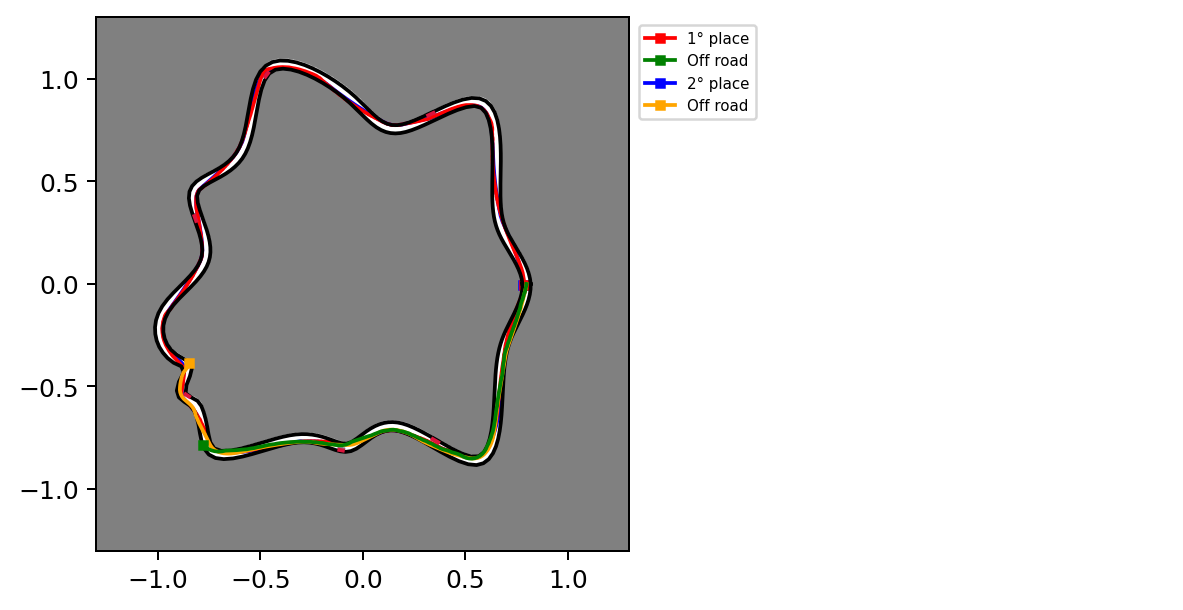

In [30]:
tracks.newrun([ddpg_model, ddpg2_model, ppo_model, sac_model])